In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Convert the json logs to table

In [2]:
def transformLogs(dirpath: str, filename: str):
    df = pd.read_json(f"{dirpath}/{filename}", orient="index")
    df = df.stack().rename_axis(["n","operation"]).reset_index(name="payload")

    df = pd.concat(
        df.apply(
            lambda row: pd.DataFrame(
                [
                    {
                        "db_size": row.n.split("_")[1],
                        "iteration": row.n.split("_")[-1],
                        "operation": (
                            row.n.split("_")[2][:-6] + row.operation
                            if row.operation in ["create", "delete"]
                            else row.n.split("_")[2][:-6]
                        ),
                        "sample": 0,
                        **row.payload["baseline"],
                        "response_time": row.payload["response_time"],
                    },
                    *[
                        {
                            "db_size": row.n.split("_")[1],
                            "iteration": row.n.split("_")[-1],
                            "operation": (
                                row.n.split("_")[2][:-6] + row.operation
                                if row.operation in ["create", "delete"]
                                else row.n.split("_")[2][:-6]
                            ),
                            **{k: v for k, v in sample.items()},
                            "response_time": row.payload["response_time"],
                        }
                        for sample in row.payload["samples"]
                    ],
                ]
            ),
            axis=1
        ).tolist(),
        ignore_index=True
    )

    df["instance"] = dirpath.split("/")[-1]

    df[[
        'db_size', 'iteration', 'sample', 'cpu_util',
        'disk_read', 'disk_write', 'disk_used', 'disk_free',
        'virtual_used', 'virtual_free', 'response_time'
    ]].astype(float)

    return df

results = []
for dirpath, _, filenames in os.walk("../logs/"):
    if dirpath.split("/")[-1] == "local":
        continue

    for filename in filenames:
        results.append(transformLogs(dirpath, filename))

df_raw = pd.concat(results)
df_raw

,db_size,iteration,operation,sample,cpu_util,disk_read,disk_write,disk_used,disk_free,virtual_used,virtual_free,response_time,instance
0,10,0,insertOnedelete,0,9.5,0.725337,5.550348,3.762451,24.239624,1.195541,2.551422,0.001833,medium
1,10,0,insertOnedelete,1,0.0,0.725337,5.550352,3.762451,24.239624,1.195541,2.551422,0.001833,medium
2,10,0,insertOnecreate,0,0.0,0.725337,5.550352,3.762451,24.239624,1.195526,2.551437,0.018558,medium
3,10,0,insertOnecreate,1,4.8,0.725337,5.550508,3.762463,24.239613,1.195496,2.551468,0.018558,medium
4,10,0,insertOne,0,0.0,0.725337,5.550543,3.762463,24.239613,1.195488,2.551476,0.000810,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,100000,4,aggregatecreate,1,52.0,39.670193,2.765177,4.926296,23.075779,1.039745,0.826122,0.743996,small
406,100000,4,aggregatecreate,2,47.6,39.670193,2.765295,4.926304,23.075771,1.040897,0.824970,0.743996,small
407,100000,4,aggregatecreate,3,50.0,39.670193,2.767565,4.928600,23.073475,1.038883,0.826984,0.743996,small
408,100000,4,aggregate,0,0.0,39.670193,2.769968,4.928600,23.073475,1.036495,0.829372,0.035801,small


# Calculate the total response time as database size increases

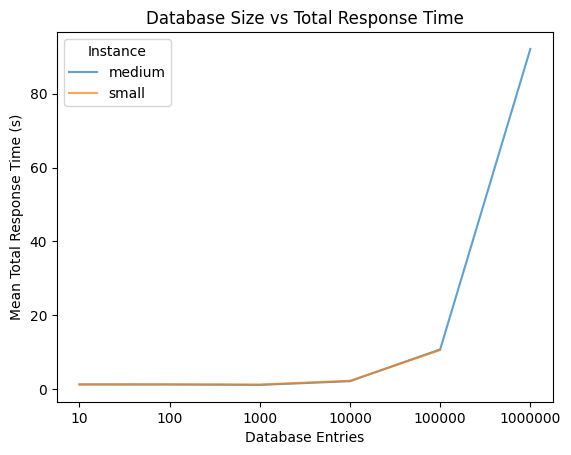

In [3]:
df = df_raw.copy(deep=True)

# filter out the base lines (before the test is run)
df = df[df["sample"] > 0]

# get the average response time of each operation
df = df.groupby(
        ["instance", "db_size", "operation"]
    )["response_time"].agg(
        ["mean"]
    ).reset_index()

# get the total response time across all the operations
df = df.groupby(
        ["instance", "db_size"]
    )["mean"].sum().reset_index()

# plot the results
plt.figure()

# plot each vm instance
for inst in df["instance"].unique():
    # filter to get subset
    subset = df[df["instance"] == inst]
    
    # plot size and average response time
    plt.plot(subset["db_size"], subset["mean"], label=inst, alpha=0.7)

# set the labels and titles
plt.xlabel("Database Entries")
plt.ylabel("Mean Total Response Time (s)")
plt.legend(title="Instance")
plt.title("Database Size vs Total Response Time")
plt.show()

# Calculate the max ram usage overall and per operation

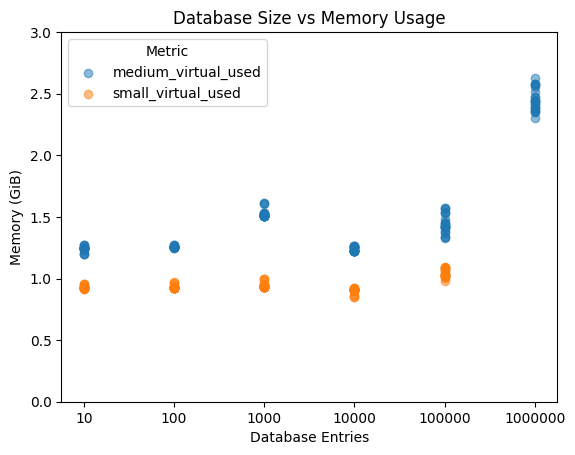

In [4]:
df = df_raw.copy(deep=True)

# filter out the base lines (before the test is run)
df = df[df["sample"] > 0]

# calculate the average memory usage
df = df.groupby(
        ["instance", "db_size", "operation"]
    )[["virtual_used", "virtual_free"]].agg(
        ["median"]
    ).reset_index()

# flatten
df.columns = [f"{lvl0}"for lvl0,_ in df.columns]

# plot
for metric in ["virtual_used"]:
    for inst in df["instance"].unique():
        # filter to get subset
        subset = df[df["instance"] == inst]
        
        # plot size and average response time
        plt.scatter(subset["db_size"], subset[metric], label=f"{inst}_{metric}", alpha=0.5)

# set labels
plt.xlabel("Database Entries")
plt.ylabel("Memory (GiB)")
plt.legend(title="Metric")
plt.title("Database Size vs Memory Usage")
plt.ylim(0, 3)
plt.show()


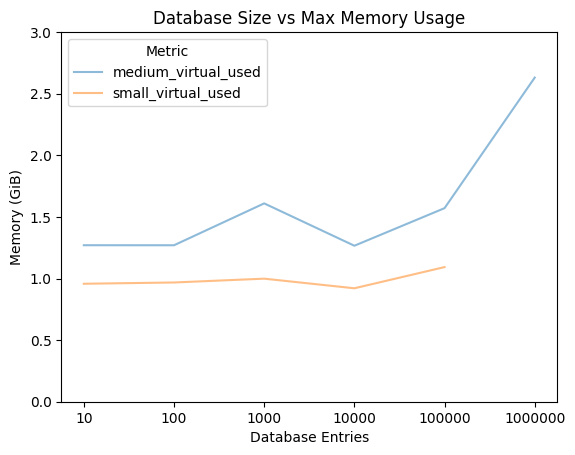

,instance,db_size,operation,virtual_used,virtual_free
0,medium,10,aggregatedelete,1.270355,2.476608
1,medium,100,insertOnedelete,1.270000,2.476963
2,medium,1000,insertOnedelete,1.609840,2.137123
3,medium,10000,readOnedelete,1.266140,2.480824
4,medium,100000,aggregate,1.571163,2.175800
5,medium,1000000,updateManycreate,2.631016,1.115948
6,small,10,insertMany,0.957508,0.908360
7,small,100,insertMany,0.967813,0.898054
8,small,1000,insertOnedelete,0.998817,0.867050
9,small,10000,readOnedelete,0.920776,0.945091


In [5]:
# view what operation uses the most memory
max_op = df.groupby(["instance", "db_size"])["virtual_used"].max().reset_index()
df = df.merge(max_op, how="right", on=["instance","db_size","virtual_used"])

for metric in ["virtual_used"]:
    for inst in df["instance"].unique():
        # filter to get subset
        subset = df[df["instance"] == inst]
        
        # plot size and average response time
        plt.plot(subset["db_size"], subset[metric], label=f"{inst}_{metric}", alpha=0.5)

# set labels
plt.xlabel("Database Entries")
plt.ylabel("Memory (GiB)")
plt.legend(title="Metric")
plt.title("Database Size vs Max Memory Usage")
plt.ylim(0, 3)
plt.show()

df

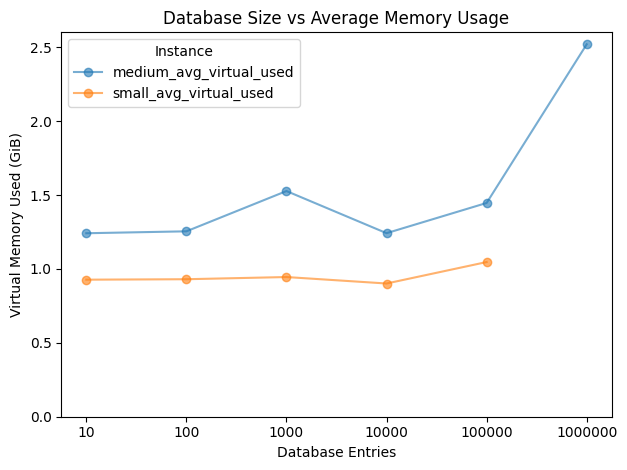

In [6]:
import matplotlib.pyplot as plt

# filter out baseline
df = df_raw[df_raw["sample"] > 0].copy()

# average memory usage
mean_mem = (
    df
    .groupby(["instance", "db_size", "operation"])[["virtual_used"]]
    .agg(["mean"])
    .reset_index()
    .groupby(["instance", "db_size"])["virtual_used"]
    .mean()
    .reset_index()
)

# flatten
mean_mem.columns = [c[0] if isinstance(c, tuple) else c for c in mean_mem.columns]

# plot
plt.figure()
for inst in mean_mem["instance"].unique():
    subset = mean_mem[mean_mem["instance"] == inst]
    plt.plot(
        subset["db_size"],
        subset["virtual_used"],
        marker="o",
        label=f"{inst}_avg_virtual_used",
        alpha=0.6
    )

plt.xlabel("Database Entries")
plt.ylabel("Virtual Memory Used (GiB)")
plt.title("Database Size vs Average Memory Usage")
plt.legend(title="Instance")
plt.tight_layout()
plt.ylim(0)
plt.show()


# Calculate Bottleneck CPU usage

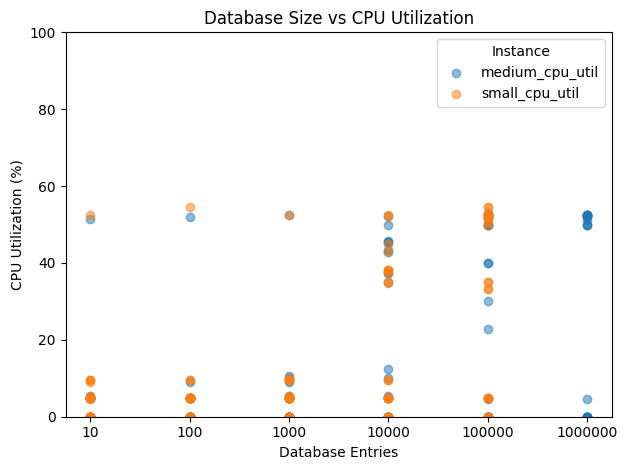

In [7]:
import matplotlib.pyplot as plt

# start from raw
df = df_raw.copy()

# filter out the base lines (before the test is run)
df = df[df["sample"] > 0]

# calculate median CPU utilization per operation
df = (
    df
    .groupby(["instance", "db_size", "operation"])[["cpu_util"]]
    .agg(["median"])
    .reset_index()
)

# flatten the MultiIndex columns
df.columns = [lvl0 for lvl0, _ in df.columns]

# === Scatter: median CPU utilization ===
plt.figure()
for inst in df["instance"].unique():
    subset = df[df["instance"] == inst]
    plt.scatter(
        subset["db_size"],
        subset["cpu_util"],
        label=f"{inst}_cpu_util",
        alpha=0.5
    )

plt.xlabel("Database Entries")
plt.ylabel("CPU Utilization (%)")
plt.title("Database Size vs CPU Utilization")
plt.legend(title="Instance")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

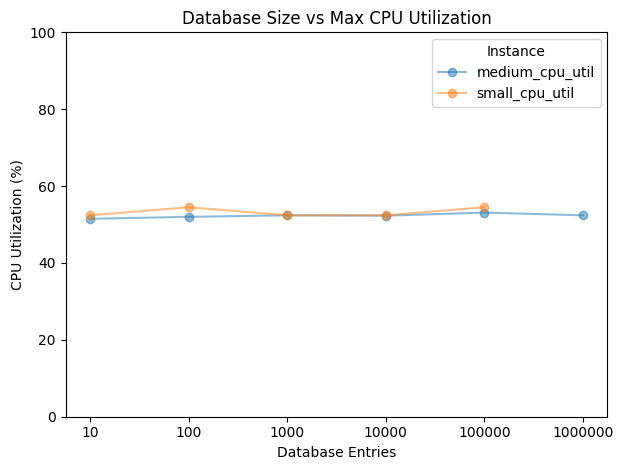

,instance,db_size,operation,cpu_util
0,medium,10,aggregate,0.00
1,medium,10,aggregatecreate,4.80
2,medium,10,aggregatedelete,0.00
3,medium,10,insertMany,51.50
4,medium,10,insertManycreate,4.80
...,...,...,...,...
259,small,100000,updateManycreate,52.05
260,small,100000,updateManydelete,4.80
261,small,100000,updateOne,35.00
262,small,100000,updateOnecreate,52.40


In [8]:
# operatios with max cpu usage
max_cpu = (
    df
    .groupby(["instance", "db_size"])["cpu_util"]
    .max()
    .reset_index()
)

# plot the max cpu usage
plt.figure()
for inst in max_cpu["instance"].unique():
    subset = max_cpu[max_cpu["instance"] == inst]
    plt.plot(
        subset["db_size"],
        subset["cpu_util"],
        marker="o",
        label=f"{inst}_cpu_util",
        alpha=0.5
    )

plt.xlabel("Database Entries")
plt.ylabel("CPU Utilization (%)")
plt.title("Database Size vs Max CPU Utilization")
plt.legend(title="Instance")
plt.tight_layout()
plt.ylim(0, 100)
plt.show()

df

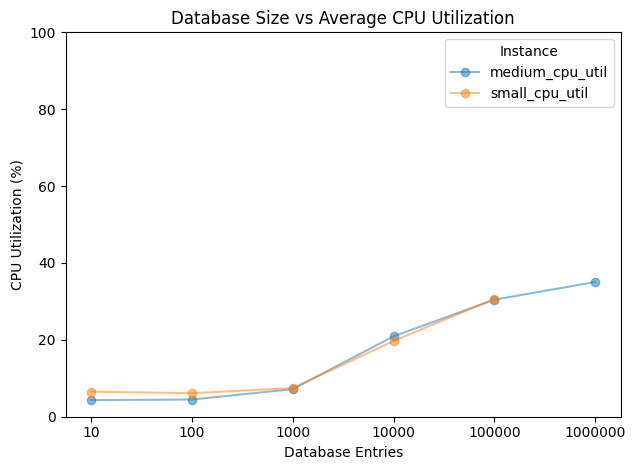

In [9]:
# start from raw
df = df_raw.copy()

# filter out the base lines (before the test is run)
df = df[df["sample"] > 0]

# calculate median CPU utilization per operation
df = (
    df
    .groupby(["instance", "db_size", "operation"])[["cpu_util"]]
    .agg(["mean"])
    .reset_index()
)

# get the avargage cpu utilization
mean_cpu = (
    df
    .groupby(["instance", "db_size"])["cpu_util"]
    .agg(["mean"])
    .reset_index()
)

# flatten
mean_cpu.columns = [c[0] if isinstance(c, tuple) else c for c in mean_cpu.columns]

# plot
plt.figure()
for inst in df["instance"].unique():
    subset = mean_cpu[mean_cpu["instance"] == inst]
    plt.plot(
        subset["db_size"],
        subset["cpu_util"],
        marker="o",
        label=f"{inst}_cpu_util",
        alpha=0.5
    )

plt.xlabel("Database Entries")
plt.ylabel("CPU Utilization (%)")
plt.title("Database Size vs Average CPU Utilization")
plt.legend(title="Instance")
plt.tight_layout()
plt.ylim(0, 100)
plt.show()


# Disk usage

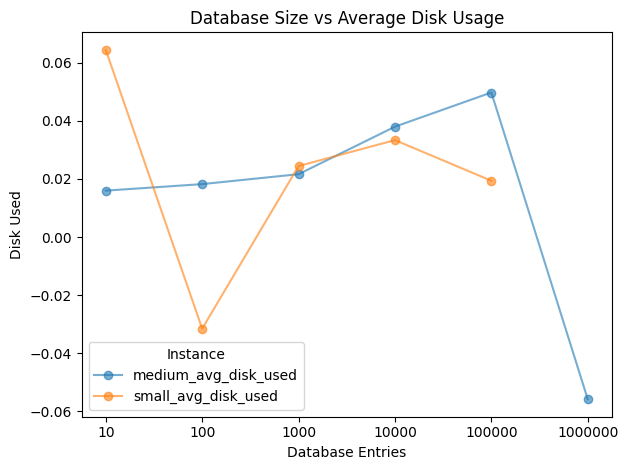

In [10]:
# filter out baseline
df = df_raw.copy(deep=True)

# calculate base disk usage
base_disk = df[df["operation"] == "insertOnedelete"]
base_disk = base_disk[base_disk["sample"] == 0]
base_disk = base_disk[base_disk["iteration"] == "0"]
base_disk = base_disk[["instance", "db_size", "disk_used"]]
base_disk = base_disk.rename(columns={"disk_used": "base_disk"})

# get the average disk usage
mean_disk = (
    df
    .groupby(["instance", "db_size", "operation"])[["disk_used"]]
    .agg(["mean"])
    .reset_index()
    .groupby(["instance", "db_size"])["disk_used"]
    .mean()
    .reset_index()
)

# flatten
mean_disk.columns = [c[0] if isinstance(c, tuple) else c for c in mean_disk.columns]

# adjust the average
mean_disk = mean_disk.merge(base_disk, how="left", on=["instance", "db_size"])
mean_disk["disk_used"] = mean_disk["disk_used"] - mean_disk["base_disk"]

# plot
plt.figure()
for inst in mean_disk["instance"].unique():
    subset = mean_disk[mean_disk["instance"] == inst]
    plt.plot(
        subset["db_size"],
        subset["disk_used"],
        marker="o",
        label=f"{inst}_avg_disk_used",
        alpha=0.6
    )

plt.xlabel("Database Entries")
plt.ylabel("Disk Used")
plt.title("Database Size vs Average Disk Usage")
plt.legend(title="Instance")
plt.tight_layout()
plt.show()


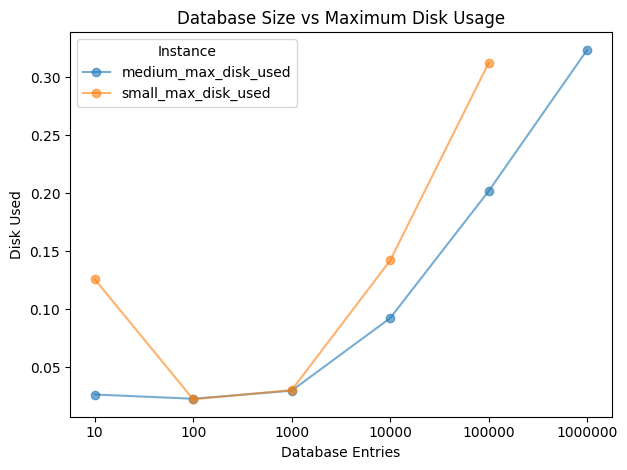

In [11]:
# get the max disk usage per operation
max_disk = (
    df
    .groupby(["instance", "db_size", "operation"])[["disk_used"]]
    .agg(["max"])
    .reset_index()
    .groupby(["instance", "db_size"])["disk_used"]
    .max()
    .reset_index()
)

# flatten
max_disk.columns = [c[0] if isinstance(c, tuple) else c for c in max_disk.columns]

# adjust with baseline
max_disk = max_disk.merge(base_disk, how="left", on=["instance", "db_size"])
max_disk["disk_used"] = max_disk["disk_used"] - max_disk["base_disk"]

# plot
plt.figure()
for inst in max_disk["instance"].unique():
    subset = max_disk[max_disk["instance"] == inst]
    plt.plot(
        subset["db_size"],
        subset["disk_used"],
        marker="o",
        label=f"{inst}_max_disk_used",
        alpha=0.6
    )

plt.xlabel("Database Entries")
plt.ylabel("Disk Used")
plt.title("Database Size vs Maximum Disk Usage")
plt.legend(title="Instance")
plt.tight_layout()
plt.show()